In [2]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyitlib import discrete_random_variable as drv

# Unzip runs.zip in NASLib/run/results/correlation before running the code

In [3]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

In [175]:
def get_all_files(root_folder='../run/results/correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                all_files.append(os.path.join(root, file))

    return all_files


def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        
        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data

def sort_by_mean(df, asc=True):
    df = df.reindex(df.transpose().mean().sort_values(ascending=asc).index)
    df = df.reindex(df.mean().sort_values(ascending=asc).index, axis=1)
    return df

def plot_heatmap(df, figsize=(20, 10), rotation=0, title='', cmap='viridis_r', savetitle='zcp_corr', savedir='.', vmin=-1, vmax=1, save=True):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap=cmap, fmt='.2f', vmin=vmin, vmax=vmax, cbar=False)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation, fontsize=12)
    heatmap.set(xlabel=None)
    heatmap.set(ylabel=None)
    plt.tight_layout()
    if savedir != '.':
        os.makedirs(savedir, exist_ok=True)
    if save:
        plt.savefig('{}/{}.pdf'.format(savedir, savetitle), bbox_inches='tight')    


def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_clean_df(preds_to_drop=None):
    files = get_all_files()
    print(files[0])
    df = make_df(files)
    return df

Note: there are many other useful methods in NASLib/plotting/PlotCorrelations.ipynb

Note: to compute the mutual information and/or entropy of a random variable (a zero-cost proxy)
if we only have samples of that random variable (e.g. 500 samples, or 15625 samples): we need to discretize the random variable. That is, make a set of bins with equal number of ZC proxy values in each bin. For example, make 10 or 100 bins, based on how many samples we have.

If we want to compute the conditional entropy conditioned on two ZC proxies, we need to create 5x5=25 bins (or 10x10=100, etc), since we need to discretize both.

In [178]:
def discretize(values, bins=10):
    bin_edges = np.histogram_bin_edges(values, bins=bins)
    bin_edges[-1] += 1
    return np.digitize(values, bin_edges)


def compute_metrics(df, predictors):
    cond_entropy_matrix = np.zeros((len(predictors), len(predictors)))
    mutual_info_matrix = np.zeros((len(predictors), len(predictors)))
    info_gain_matrix = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['predictor'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['predictor'] == zc_2]['preds'].to_list()[0])
            truths = np.array(df[df['predictor'] == zc_1]['ground_truth'].to_list()[0])
            
            n_bins = int(np.round(1+3.322*np.log(len(preds_1))))
            preds_1_disc = discretize(preds_1, bins=n_bins)
            preds_2_disc = discretize(preds_2, bins=n_bins)
            truths_disc = discretize(truths, bins=n_bins)

            try:
                length = len(preds_1)
                if length != len(preds_2) or length != len(truths):
                    print(zc_1, zc_2, len(zc_1), len(zc_2), 'prediction sizes do not match')
                    continue
            except:
                print(zc_1, preds_1)
                print(zc_2, preds_2)
            
            ent_1 = drv.entropy_conditional(truths_disc, preds_1_disc)
            ent_2 = drv.entropy_conditional(truths_disc, preds_2_disc)
            info = drv.information_mutual(preds_1_disc, preds_2_disc)

            rank_1 = np.corrcoef(preds_1, truths)[0, 1]
            rank_2 = np.corrcoef(preds_2, truths)[0, 1]
            
            # compute H(truths | preds_1, preds_2) and I(truths, preds_1, preds_2), all discretized
            all_joint_ent = drv.entropy_joint([preds_1_disc, preds_2_disc, truths_disc])
            preds_joint_ent = drv.entropy_joint([preds_1_disc, preds_2_disc])
            duo_cond_ent = all_joint_ent - preds_joint_ent
            sing_cond_ent = ent_1 - duo_cond_ent
            duo_info = drv.entropy(truths_disc) - duo_cond_ent
            cond_entropy_matrix[i,j] = duo_cond_ent
            mutual_info_matrix[i,j] = duo_info
            info_gain_matrix[i,j] = sing_cond_ent
            
    return cond_entropy_matrix, mutual_info_matrix, info_gain_matrix

def plot_conditional_entropy(df, search_space, dataset):
    all_entropy = []
    all_info = []
    all_gain = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        
        predictors = tuple(set(df_['predictor'].to_list()))

        cond_entropy, mutual_info, info_gain= compute_metrics(df_, predictors)
        all_entropy.append(cond_entropy)
        all_info.append(mutual_info)
        all_gain.append(info_gain)

    entropy = np.mean(np.array(all_entropy), axis=0)
    info = np.mean(np.array(all_info), axis=0)
    gain = np.mean(np.array(all_gain), axis=0)
    
    predictors_map = {i: predictors[i] for i in range(len(predictors))}

    ent_df = pd.DataFrame(entropy)
    ent_df = ent_df.rename(columns=predictors_map, index=predictors_map)
    ent_df = sort_by_mean(ent_df)
    plot_heatmap(ent_df, title=f'{search_space}-{dataset}', figsize=(10,8),
                 savedir='entropy_given_zcs', savetitle=f'{search_space}-{dataset}', vmin=0, vmax=3, save=False)
    
    info_df = pd.DataFrame(info)
    info_df = info_df.rename(columns=predictors_map, index=predictors_map)
    info_df = sort_by_mean(info_df, asc=False)
    plot_heatmap(info_df, title=f'{search_space}-{dataset}', figsize=(10,8),
                 savedir='mutual_info_given_zcs', savetitle=f'{search_space}-{dataset}', vmin=-1, vmax=1, save=False)  

    gain_df = pd.DataFrame(gain)
    gain_df = info_df.rename(columns=predictors_map, index=predictors_map)
    gain_df = sort_by_mean(gain_df, asc=False)
    plot_heatmap(gain_df, title=f'{search_space}-{dataset}', figsize=(10,8),
                 savedir='infogain_given_zcs', savetitle=f'{search_space}-{dataset}', vmin=-1, vmax=1, save=False) 

../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


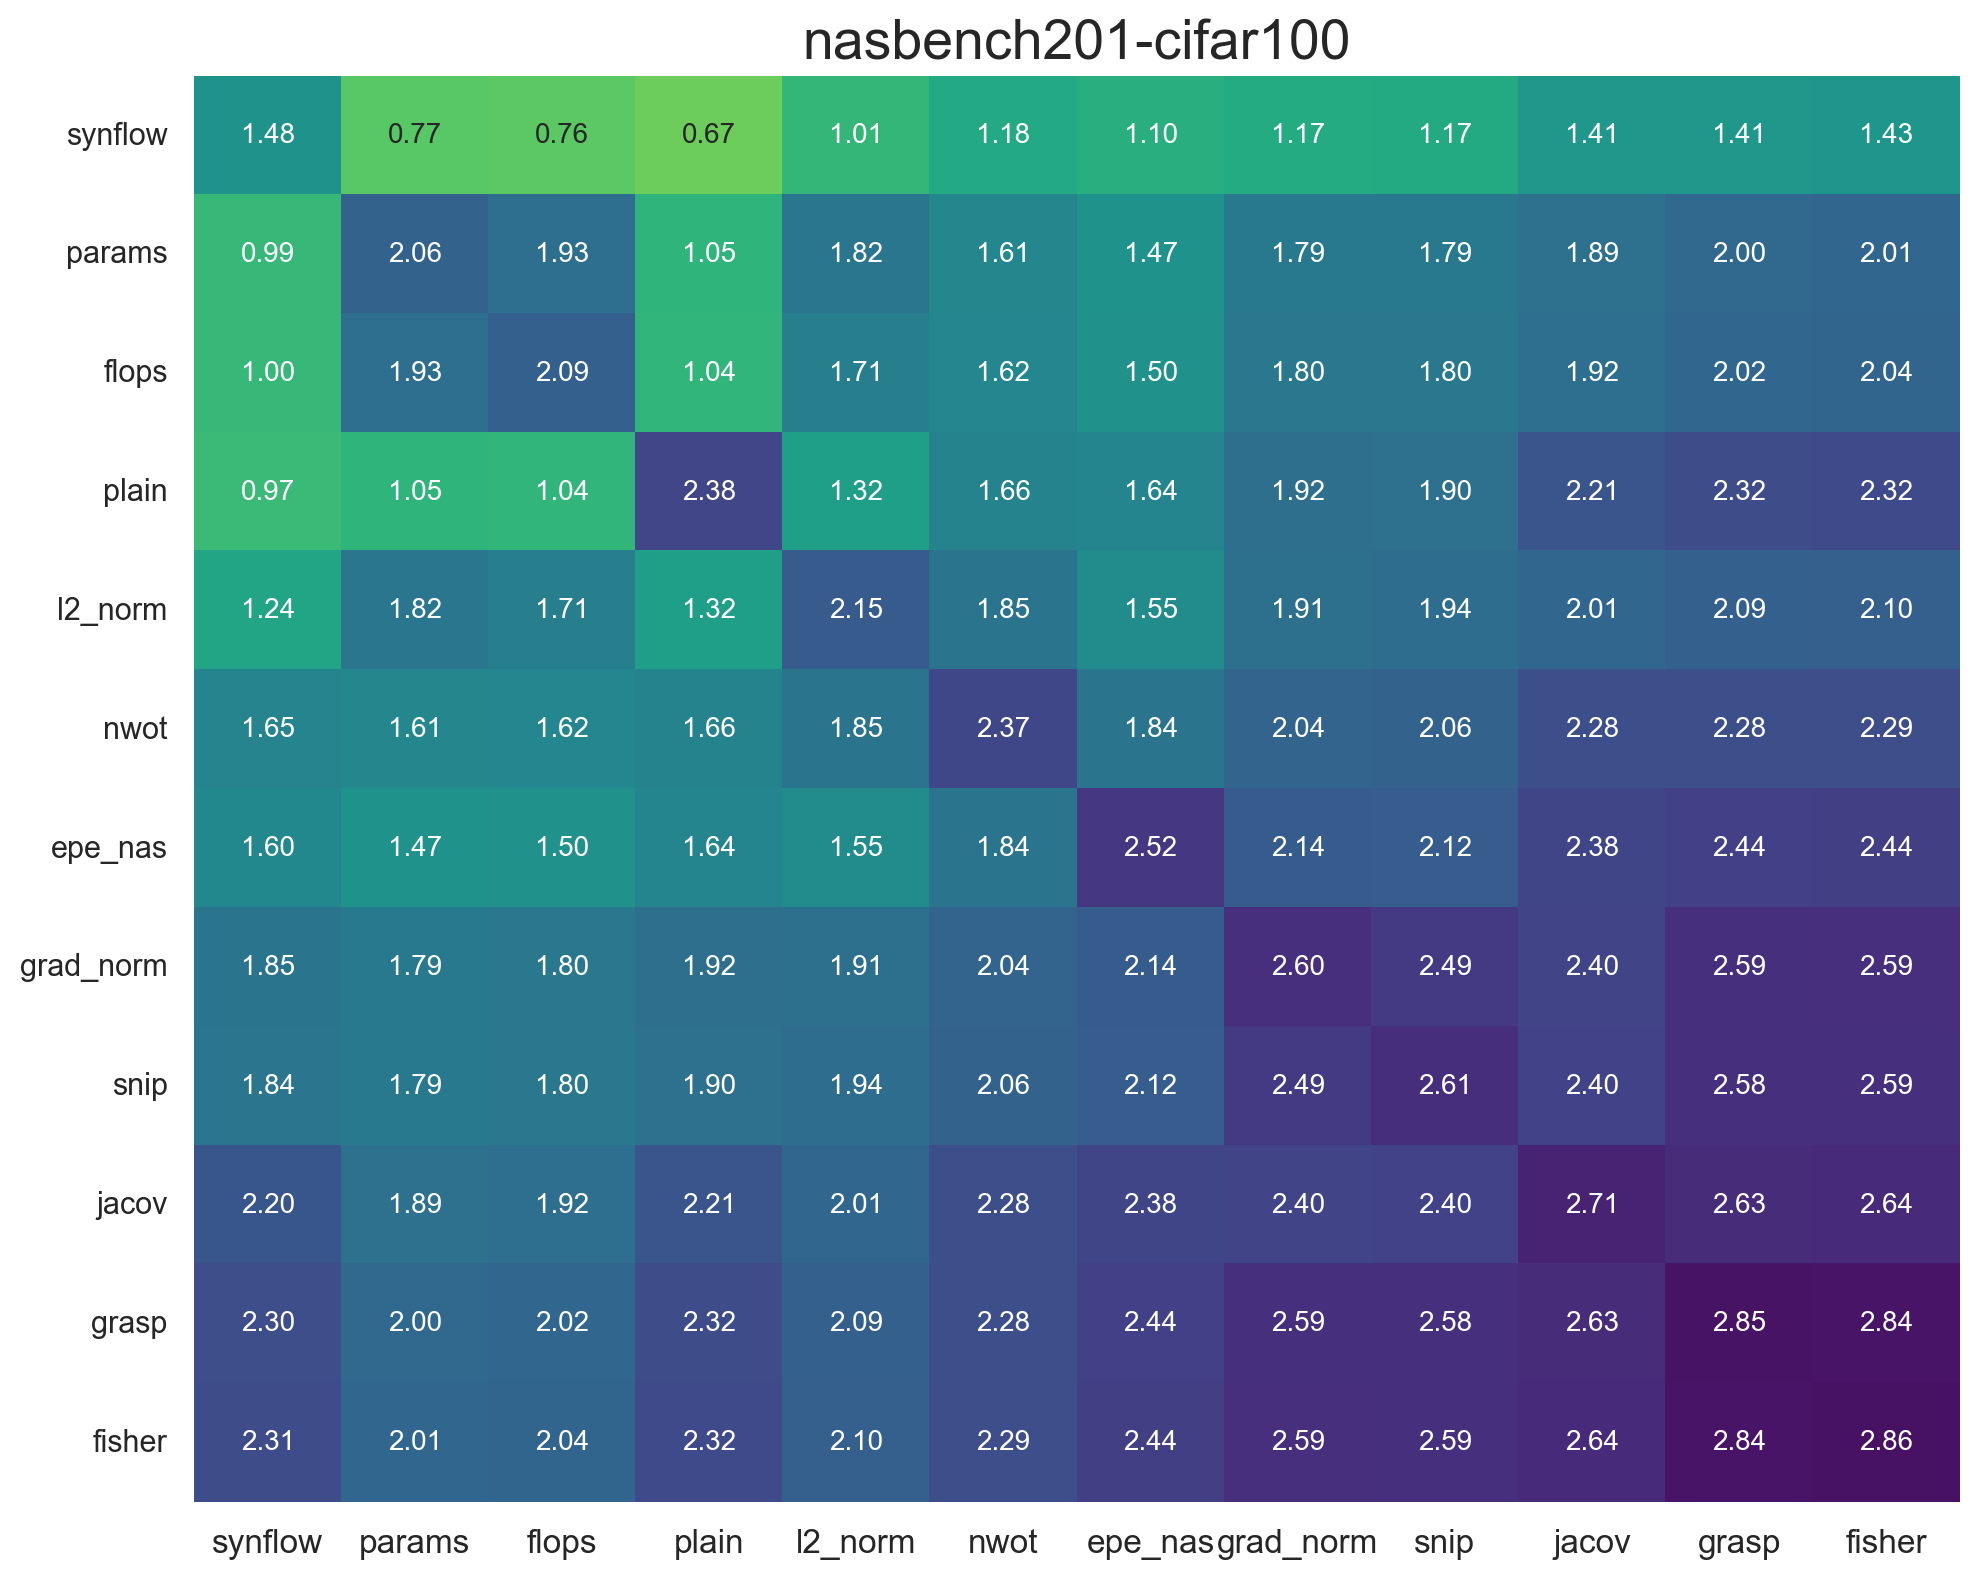

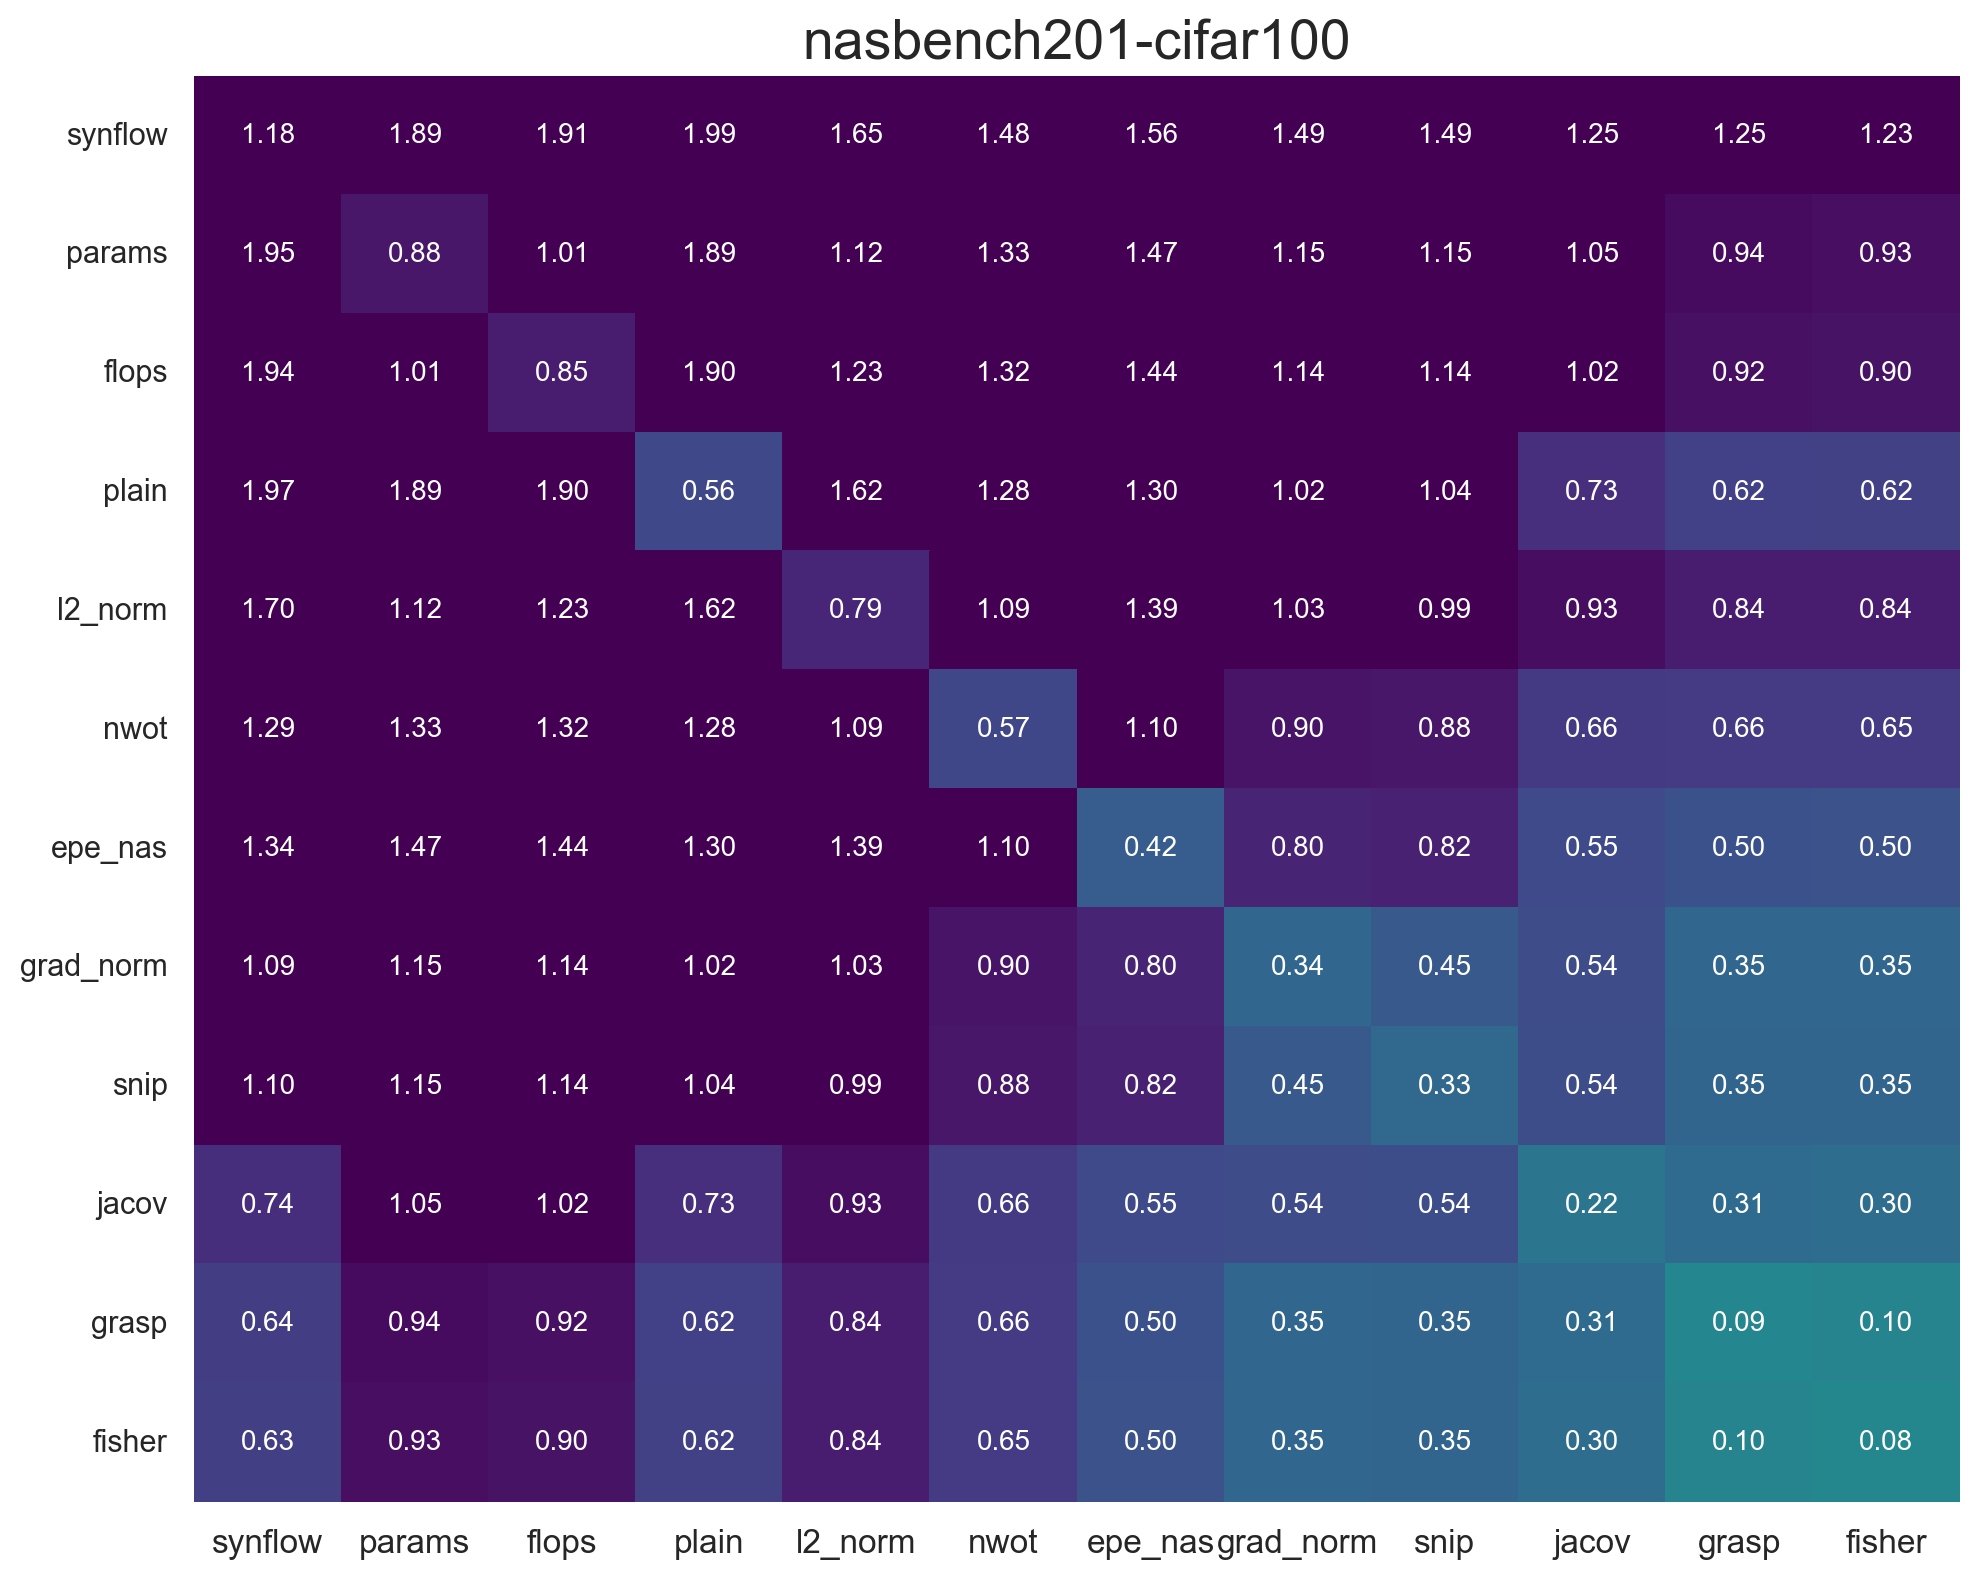

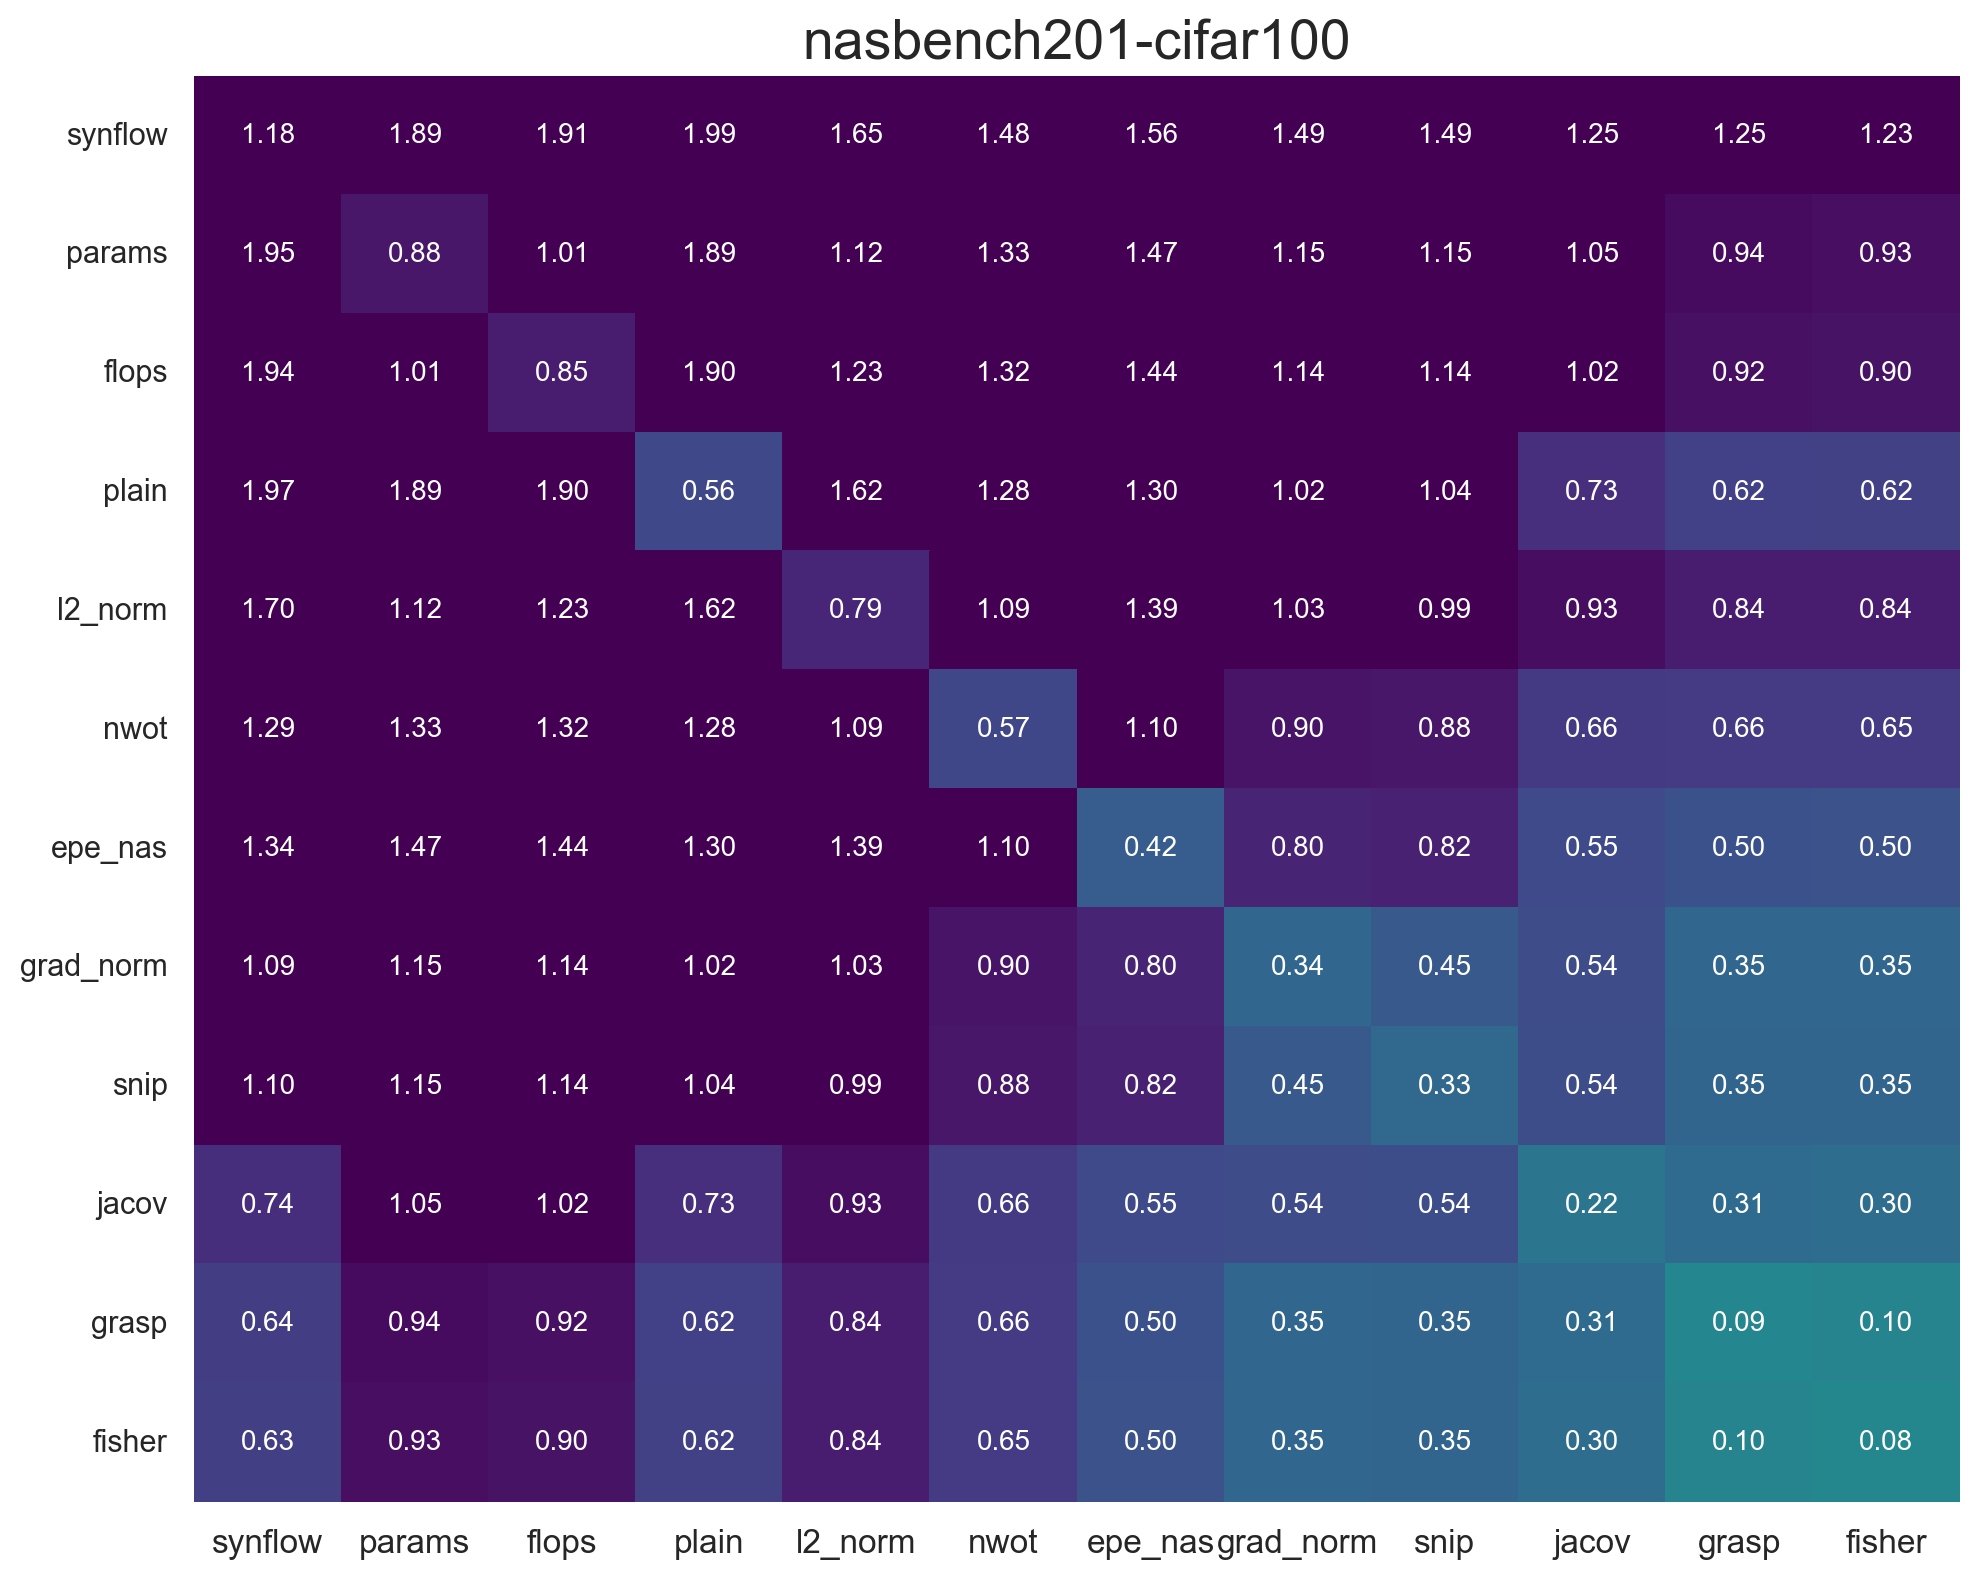

In [179]:
df = make_clean_df()

plot_conditional_entropy(df, 'nasbench201', 'cifar100')